In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle

- http://networkrepository.com/citeseer.php
- http://snap.stanford.edu/data/ca-GrQc.html
- https://towardsdatascience.com/learning-in-graphs-with-python-part-3-8d5513eef62d
- https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html#graph-generators-and-graph-operations

In [2]:
# citeseer data
edges = pd.read_csv('./data/citeseer.edges',header=None,names=['s','t','w'])
nodes = pd.read_csv('./data/citeseer.node_labels',header=None,names=['node','y'])

***Create undirected graph***

In [3]:
G=nx.Graph(name='citeseer')
for x in list(nodes['node'].unique()): G.add_node(x) 
G.add_edges_from([(i,e,{'weight':1}) for i,e in edges[['s','t']].values])

G.graph
# view
# G.edges(data=True)

{'name': 'citeseer'}

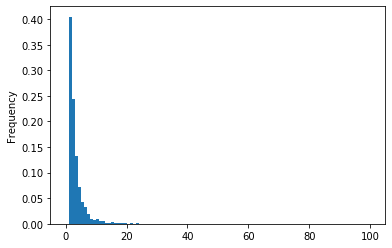

In [4]:
node_degree = [i for i in nx.degree(G)]
node_degree = pd.DataFrame(node_degree,columns=['node','degree'])
node_degree['degree'].plot.hist(density=True,bins=np.arange(0,101,1));

In [5]:
sg = [G.subgraph(c) for c in nx.connected_components(G)]
print(f'Subgraphs: {len(sg)}')
pd.DataFrame([len(g) for g in sg]).describe().T

Subgraphs: 390


,count,mean,std,min,25%,50%,75%,max
0,390.0,8.369231,106.714751,2.0,2.0,2.0,3.0,2110.0


***View the graph***

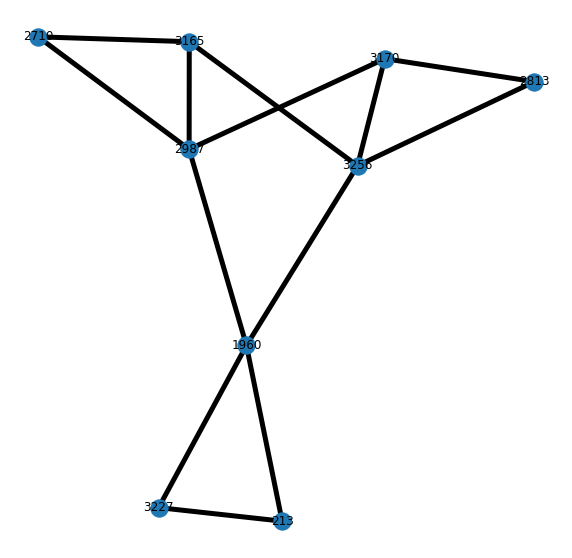

In [47]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

nx.draw_spring(sg[50], ax=ax,
               #node_size=degree*100,
               with_labels=True,
               cmap = plt.get_cmap('jet'),
               #node_color = values,
               width=5)

***Node2Vec***

The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective. The objective is flexible, and the algorithm accomodates for various definitions of network neighborhoods by simulating biased random walks. Specifically, it provides a way of balancing the exploration-exploitation tradeoff that in turn leads to representations obeying a spectrum of equivalences from homophily to structural equivalence. [ref](https://snap.stanford.edu/node2vec/)

 - https://github.com/eliorc/node2vec
 - [snap implementation](https://snap.stanford.edu/node2vec/)
 
[*node2vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016.*](http://arxiv.org/abs/1607.00653)


In [7]:
from node2vec import Node2Vec

In [8]:
# load or train
try: 
    node2vec = pickle.load(open( "n2v-node2vec.p", "rb" ))
    model = pickle.load(open( "n2v-model.p", "rb" ))
    print('Loaded n2v and model')
    
except:
    print('Training: node2vec...')
    # pre-compute the probabilities and generate walks :
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    pickle.dump(node2vec, open( "n2v-node2vec.p", "wb" ))
    
    
    # We can then embed the nodes
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    pickle.dump(model, open( "n2v-model-nodes.p", "wb" ))

Loaded n2v and model


It has a length of 64 since we defined the dimension as 64 above. What can we do with this embedding? One of the first options is for example to identify the most similar node!

In [30]:
# find similar nodes to specific node
nid = 5
print(model.wv.get_vector(f'{nid}'))
nids = [int(x[0]) for x in model.wv.most_similar(f'{nid}')]+[int(nid)]
node_degree.loc[node_degree['node'].isin(nids)]

[ 0.84098434 -0.06631394 -0.68943346  2.6253424  -0.1438494   0.40386316
  1.2153159   0.9718991   1.0965265  -0.21448207  0.17439339  0.20423417
  1.0548857  -1.7976708  -0.65017396  0.73202     0.67886114  0.504003
  0.9701172   0.11826791 -1.2746447  -0.41726863  3.6250882  -1.2851148
 -0.3848583   0.42979738  1.9652413   2.2215762   0.9742483  -0.48625875
 -0.3857765  -0.08943172 -1.0182638  -1.4224672  -1.6820565  -2.1338875
  0.22706138  0.9634666   1.3396124  -2.1975055   0.44577134 -0.33277795
  0.3876484   1.5440478   2.2225358   0.30547288  0.01168693 -1.0539453
  2.345289    1.4586848   3.0167649   0.6066295   0.8198288   1.035266
 -1.0117002   2.6470556   2.0257878  -0.04716391 -0.5025556   0.5350383
  0.98863083 -1.3929491   0.3929465  -0.2394877 ]


,node,degree
4,5,2
9,10,1
33,34,11
626,627,4
635,636,2
640,641,2
659,660,2
773,774,4
795,796,2
2924,2925,1


If the nodes have labels, we can train an algorithm based on the embedding and attach a label (node labeling, most similar node…)

***Edge Embedding***

Edges can also be embedded, and the embedding can be further used for classification.

In [31]:
from node2vec.edges import HadamardEmbedder

In [32]:
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [38]:
#Then, retrieve the vectors by specifying the name of the 2 linked nodes :
edges_embs[('1','100')]

array([ 4.2992563e+00, -4.9499097e-01, -5.1716070e+00, -1.0801549e+00,
       -1.6924486e+00, -1.0157824e+00,  1.7559286e+00,  6.1162324e+00,
       -2.6054120e-01,  7.8773866e+00,  3.9397024e-02, -9.6151257e-01,
        1.0161518e+00, -7.5865984e-01, -4.4435110e+00,  2.0217226e+00,
        4.4855218e+00,  1.6550004e+00,  2.8779233e-02, -1.8468572e-01,
       -5.4342747e-01, -1.8878479e+00,  1.3857514e+00,  6.9268304e-01,
       -6.3735991e+00, -3.6445935e+00,  2.5600499e-01,  1.9967386e+00,
        8.7286182e-02,  4.3110275e+00,  4.1929856e-01,  2.4604151e-01,
       -2.4651691e-01,  6.4571956e-03,  1.4673662e+00,  2.1245878e+00,
        7.4956179e-02, -1.1383138e+00,  4.9026985e+00, -2.2005148e-01,
       -7.6781911e-01, -9.3788959e-02, -4.2516494e-01, -4.6298516e-01,
        2.5801196e+00, -1.7090150e+00, -5.3007531e-01, -4.7584119e-01,
        2.3731878e+00,  3.7998393e-01,  8.9577027e-02,  3.5755427e+00,
        1.6100633e+00,  4.0723915e+00,  1.3249979e+00,  9.5535583e+00,
      

In [ ]:
# Again, we can retrieve the most similar edge, which can be used for missing 
# edges prediction for example :
try: 
    edges_kv = pickle.load(open( "n2v-model-edges.p", "rb" ))
    print('Loaded n2v edge embedding')
    
except:
    print('Training: n2v edge embedding...')
    # pre-compute the probabilities and generate walks :
    edges_kv = edges_embs.as_keyed_vectors()
    pickle.dump(edges_kv, open( "n2v-model-edges.p", "wb" ))

In [42]:
edges_kv.most_similar(str(('1', '2')))

[("('1', '31')", 0.9896529316902161),
 ("('2', '2501')", 0.9877727627754211),
 ("('2', '836')", 0.985264003276825),
 ("('2', '758')", 0.984370768070221),
 ("('2', '734')", 0.9842435121536255),
 ("('2', '691')", 0.9841132164001465),
 ("('2', '612')", 0.9802262187004089),
 ("('2', '759')", 0.9800059795379639),
 ("('187', '2')", 0.9794591069221497),
 ("('2', '757')", 0.9758082628250122)]